In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import json_normalize
from pymongo import MongoClient, errors
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import os
from pathlib import Path
from string import punctuation
from bs4 import BeautifulSoup
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim import corpora
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import guidedlda
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [2]:
def remove_punctuation(string, punctuation):
    # remove given punctuation marks from a string
    for character in punctuation:
        string = string.replace(character, '')
    return string

In [3]:
def lemmatize_str(string):
    # Lemmatize a string and return it in its original format
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(w)
                    for w in w_tokenizer.tokenize(string)
                    if "http" not in w])

In [4]:
def clean_column(df, column):
    # Apply data cleaning pipeline to a given pandas DataFrame column
    df[column] = df[column].apply(lambda x: str(x).lower())
    df[column] = df[column].apply(lambda x: remove_punctuation(x, punctuation))
    df[column] = df[column].apply(lambda x: lemmatize_str(x))
    return

In [5]:
stopwords = set(STOPWORDS)
stopwords.update(["trump", "biden", "realdonaldtrump", "rt", "joe", "joebiden", "president", "debate", "wa", "ha"])

In [6]:
all_df = pd.read_json('../data/concatenated_abridged.jsonl', lines = True)

In [7]:
all_df.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,quoted_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,extended_entities,withheld_in_countries
0,2020-09-29 23:59:56+00:00,1311093385688735744,1311093385688735744,Biden a professional debater?? Hardly!! More ...,False,"[0, 71]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,{'created_at': 'Tue Sep 29 23:12:13 +0000 2020...,0,0,False,False,0.0,en,NaN,NaN,NaN
1,2020-09-29 23:59:58+00:00,1311093394400333824,1311093394400333824,RT @DarDar458: #PresidentialDebate #Debates202...,False,"[0, 73]","{'hashtags': [{'text': 'PresidentialDebate', '...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,NaN,1,0,False,False,NaN,und,{'created_at': 'Tue Sep 29 23:55:42 +0000 2020...,NaN,NaN
2,2020-09-30 00:00:00+00:00,1311093401652277252,1311093401652277248,How can Biden stand a chance against Trump in ...,False,"[0, 280]","{'hashtags': [{'text': 'VarneyCo', 'indices': ...","<a href=""https://studio.twitter.com"" rel=""nofo...",NaN,NaN,...,NaN,25,100,False,False,0.0,en,NaN,"{'media': [{'id': 1310969778111217665, 'id_str...",NaN
3,2020-09-30 00:00:02+00:00,1311093410737070086,1311093410737070080,RT @abbydphillip: Very reminiscent of pre-2018...,False,"[0, 108]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,NaN,351,0,False,False,NaN,en,{'created_at': 'Tue Sep 29 23:00:28 +0000 2020...,NaN,NaN
4,2020-09-30 00:00:04+00:00,1311093419100561408,1311093419100561408,RT @RudyGiuliani: Why was Corrupt Biden’s son ...,False,"[0, 110]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,NaN,15672,0,False,False,NaN,en,{'created_at': 'Tue Sep 29 19:07:59 +0000 2020...,NaN,NaN


In [8]:
clean_column(all_df, 'full_text')

In [9]:
all_df.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,quoted_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,extended_entities,withheld_in_countries
0,2020-09-29 23:59:56+00:00,1311093385688735744,1311093385688735744,biden a professional debater hardly more like ...,False,"[0, 71]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,{'created_at': 'Tue Sep 29 23:12:13 +0000 2020...,0,0,False,False,0.0,en,NaN,NaN,NaN
1,2020-09-29 23:59:58+00:00,1311093394400333824,1311093394400333824,rt dardar458 presidentialdebate debates2020 tr...,False,"[0, 73]","{'hashtags': [{'text': 'PresidentialDebate', '...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,NaN,1,0,False,False,NaN,und,{'created_at': 'Tue Sep 29 23:55:42 +0000 2020...,NaN,NaN
2,2020-09-30 00:00:00+00:00,1311093401652277252,1311093401652277248,how can biden stand a chance against trump in ...,False,"[0, 280]","{'hashtags': [{'text': 'VarneyCo', 'indices': ...","<a href=""https://studio.twitter.com"" rel=""nofo...",NaN,NaN,...,NaN,25,100,False,False,0.0,en,NaN,"{'media': [{'id': 1310969778111217665, 'id_str...",NaN
3,2020-09-30 00:00:02+00:00,1311093410737070086,1311093410737070080,rt abbydphillip very reminiscent of pre2018 el...,False,"[0, 108]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,NaN,351,0,False,False,NaN,en,{'created_at': 'Tue Sep 29 23:00:28 +0000 2020...,NaN,NaN
4,2020-09-30 00:00:04+00:00,1311093419100561408,1311093419100561408,rt rudygiuliani why wa corrupt biden’s son bei...,False,"[0, 110]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,NaN,15672,0,False,False,NaN,en,{'created_at': 'Tue Sep 29 19:07:59 +0000 2020...,NaN,NaN


In [10]:
english_df = all_df["lang"] == "en"

In [11]:
all_df = all_df[english_df]

In [12]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [13]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

/Users/jeffbauerle/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


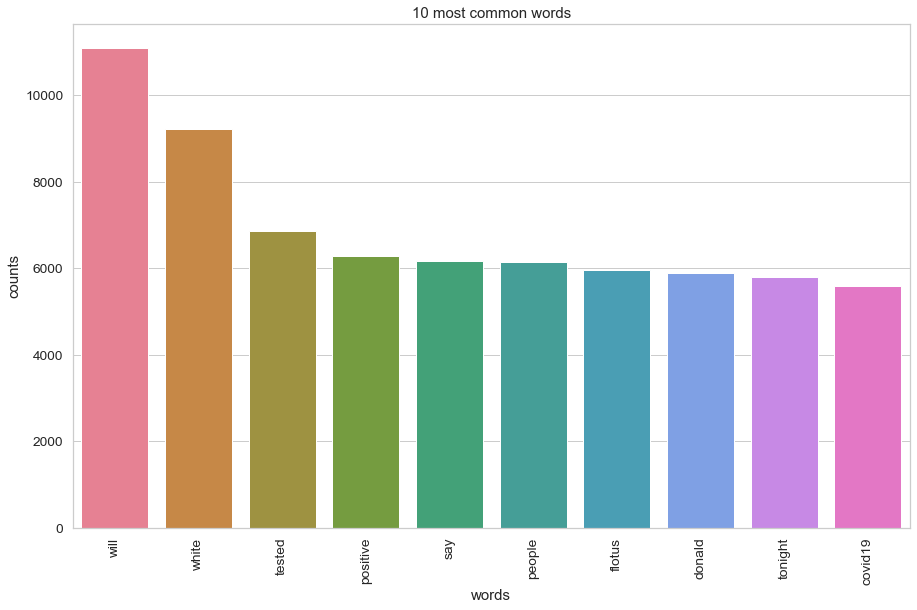

In [15]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words=stopwords)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(all_df['full_text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [16]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [17]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
will flotus tonight positive covid19 tested recovery wallace white immediately

Topic #1:
want time ballot year say tax new one donald amp

Topic #2:
thank will everyone negative happy report time jill covid tested

Topic #3:
white state america stand supremacist vote united last night say

Topic #4:
people covid american know mask amp will first hope got


In [20]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))

CPU times: user 36 µs, sys: 17 µs, total: 53 µs
Wall time: 58.2 µs


In [21]:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

In [23]:
with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

In [25]:
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

In [26]:
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')